In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim


In [4]:
#Loading dataset with HR images from DIV2K and creating matching LR inputs
class Dataset_DIV2K_HR_LR(Dataset):
    def __init__(self, root_dir: str):
        #Collecting image file paths from the directory
        self.image_paths = sorted([
            os.path.join(root_dir, img) for img in os.listdir(root_dir)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        print(f"Loaded {len(self.image_paths)} images from {root_dir}")

        #Tranform for HR images
        #Crop to target size and converting them to tensor
        self.hr_transform = transforms.Compose([
            transforms.CenterCrop(CROP_SIZE),
            transforms.ToTensor()
        ])

        #Transform for LR images
        #Crop, downscale using bicubic, and converting to tensor
        self.lr_transform = transforms.Compose([
            transforms.CenterCrop(CROP_SIZE),
            transforms.Resize(CROP_SIZE // UPSCALE_FACTOR, interpolation=Image.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        #Returning total number of images
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        #After we get the image, converting it to RGB
        img = Image.open(self.image_paths[idx]).convert("RGB")
        #Generating HR and LR versions of the img
        hr_img = self.hr_transform(img)
        lr_img = self.lr_transform(img)
        return lr_img, hr_img, os.path.basename(self.image_paths[idx])


In [5]:
# Config and training hyperparameters
TRAIN_DIR = "C:/Users/Deekshith Sanem/Downloads/apppu/DIV2K_train_HR/DIV2K_train_HR"
VAL_DIR = "C:/Users/Deekshith Sanem/Downloads/apppu/DIV2K_valid_HR/DIV2K_valid_HR"
CROP_SIZE = 128
UPSCALE_FACTOR = 2
BATCH_SIZE = 8
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
COMPUTE_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
#Creating training and validation datasets
dataset_train = Dataset_DIV2K_HR_LR(TRAIN_DIR)
dataset_valid = Dataset_DIV2K_HR_LR(VAL_DIR)

#Creating dataloaders for batch processing
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)


Loaded 800 images from C:/Users/Deekshith Sanem/Downloads/apppu/DIV2K_train_HR/DIV2K_train_HR
Loaded 100 images from C:/Users/Deekshith Sanem/Downloads/apppu/DIV2K_valid_HR/DIV2K_valid_HR


In [7]:
class ModelESPCN(nn.Module):
    def __init__(self, scale_factor: int = UPSCALE_FACTOR):
        super(ModelESPCN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.Conv2d(32, 3 * (scale_factor ** 2), kernel_size=3, padding=1)
        )
        #Using pixel shuffle layer to upscale the image
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    #Upscaling the input image
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layers(x)
        x = self.pixel_shuffle(x)
        return x


In [8]:
# Instantiate model, loss, optimizer
modelESPCN = ModelESPCN(scale_factor=UPSCALE_FACTOR).to(COMPUTE_DEVICE)
lossMSE = nn.MSELoss()
optimAdam = optim.Adam(modelESPCN.parameters(), lr=LEARNING_RATE)


In [9]:
def trainESPCN(model: nn.Module, train_loader: DataLoader, valid_loader: DataLoader, epochs: int = NUM_EPOCHS):
  train_loss_hist, valid_loss_hist, psnr_hist, ssim_hist = [], [], [], []

  for epoch_idx in range(epochs):
      model.train()
      epoch_train_loss = 0.0
      t0 = time.time()

      for lr_img, hr_img, _ in train_loader:
          lr_img, hr_img = lr_img.to(COMPUTE_DEVICE), hr_img.to(COMPUTE_DEVICE)
          optimAdam.zero_grad()
          sr_img = model(lr_img)
          loss = lossMSE(sr_img, hr_img)
          loss.backward()
          optimAdam.step()
          epoch_train_loss += loss.item()

      avg_train_loss = epoch_train_loss / len(train_loader)
      train_loss_hist.append(avg_train_loss)

      # Validation
      model.eval()
      epoch_valid_loss = 0.0
      psnr_sum, ssim_sum = 0.0, 0.0

      with torch.no_grad():
          for lr_img, hr_img, _ in valid_loader:
              lr_img, hr_img = lr_img.to(COMPUTE_DEVICE), hr_img.to(COMPUTE_DEVICE)
              sr_img = model(lr_img)
              val_loss = lossMSE(sr_img, hr_img)
              epoch_valid_loss += val_loss.item()

              # Calculating PSNR and SSIM per image
              for i in range(sr_img.size(0)):
                  sr_pi = sr_img[i].cpu().clamp(0, 1)
                  hr_pi = hr_img[i].cpu().clamp(0, 1)

                  psnr_val = compare_psnr(
                      hr_pi.permute(1, 2, 0).numpy(),
                      sr_pi.permute(1, 2, 0).numpy(),
                      data_range=1.0
                  )
                  ssim_val = compare_ssim(
                      hr_pi.permute(1, 2, 0).numpy(),
                      sr_pi.permute(1, 2, 0).numpy(),
                      channel_axis=-1,
                      data_range=1.0
                  )
                  psnr_sum += psnr_val
                  ssim_sum += ssim_val

      avg_valid_loss = epoch_valid_loss / len(valid_loader)
      avg_psnr = psnr_sum / len(valid_loader.dataset)
      avg_ssim = ssim_sum / len(valid_loader.dataset)

      valid_loss_hist.append(avg_valid_loss)
      psnr_hist.append(avg_psnr)
      ssim_hist.append(avg_ssim)

      dt = time.time() - t0
      print(f"Epoch [{epoch_idx+1}/{epochs}] | Time: {dt:.2f}s | "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_valid_loss:.4f} | "
            f"PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")

  return train_loss_hist, valid_loss_hist, psnr_hist, ssim_hist


In [10]:
hist_train_loss, hist_valid_loss, hist_psnr, hist_ssim = trainESPCN(
    modelESPCN, loader_train, loader_valid, epochs=NUM_EPOCHS
)

Epoch [1/50] | Time: 120.30s | Train Loss: 0.0525 | Val Loss: 0.0212 | PSNR: 17.70 | SSIM: 0.4276
Epoch [2/50] | Time: 101.61s | Train Loss: 0.0176 | Val Loss: 0.0142 | PSNR: 19.45 | SSIM: 0.5109
Epoch [3/50] | Time: 101.48s | Train Loss: 0.0123 | Val Loss: 0.0109 | PSNR: 20.60 | SSIM: 0.5943
Epoch [4/50] | Time: 101.55s | Train Loss: 0.0096 | Val Loss: 0.0086 | PSNR: 21.73 | SSIM: 0.6425
Epoch [5/50] | Time: 108.35s | Train Loss: 0.0079 | Val Loss: 0.0072 | PSNR: 22.60 | SSIM: 0.6718
Epoch [6/50] | Time: 104.13s | Train Loss: 0.0068 | Val Loss: 0.0062 | PSNR: 23.37 | SSIM: 0.6968
Epoch [7/50] | Time: 101.44s | Train Loss: 0.0060 | Val Loss: 0.0055 | PSNR: 23.90 | SSIM: 0.7193
Epoch [8/50] | Time: 102.01s | Train Loss: 0.0054 | Val Loss: 0.0050 | PSNR: 24.51 | SSIM: 0.7350
Epoch [9/50] | Time: 101.61s | Train Loss: 0.0049 | Val Loss: 0.0046 | PSNR: 25.01 | SSIM: 0.7543
Epoch [10/50] | Time: 101.75s | Train Loss: 0.0045 | Val Loss: 0.0043 | PSNR: 25.41 | SSIM: 0.7643
Epoch [11/50] | Tim

In [11]:
def plotTrainingMetrics(train_losses, val_losses, psnrs, ssims):
    epochs = range(1, len(train_losses) + 1)
    os.makedirs("results_espcn", exist_ok=True)

    plt.figure(figsize=(14, 10))

    # 1. Loss vs Epoch graph
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, val_losses, label="Val Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.grid(True)
    plt.legend()

    # 2. PSNR and SSIM
    plt.subplot(2, 2, 2)
    plt.plot(epochs, psnrs, label="PSNR", marker='o')
    plt.plot(epochs, ssims, label="SSIM", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("PSNR and SSIM over Epochs")
    plt.grid(True)
    plt.legend()

    # 3. Change in PSNR/SSIM between epochs
    plt.subplot(2, 2, 3)
    plt.plot(epochs[1:], np.diff(psnrs), label="Δ PSNR", marker='o')
    plt.plot(epochs[1:], np.diff(ssims), label="Δ SSIM", marker='x')
    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Change")
    plt.title("PSNR and SSIM Improvement per Epoch")
    plt.grid(True)
    plt.legend()

    # 4. Loss Gap between training and validation
    plt.subplot(2, 2, 4)
    loss_gap = np.array(val_losses) - np.array(train_losses)
    plt.plot(epochs, loss_gap, label="Val - Train Loss", color="purple", marker='o')
    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Gap")
    plt.title("Validation - Train Loss Gap")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig("results_espcn/metrics.png")
    plt.show()


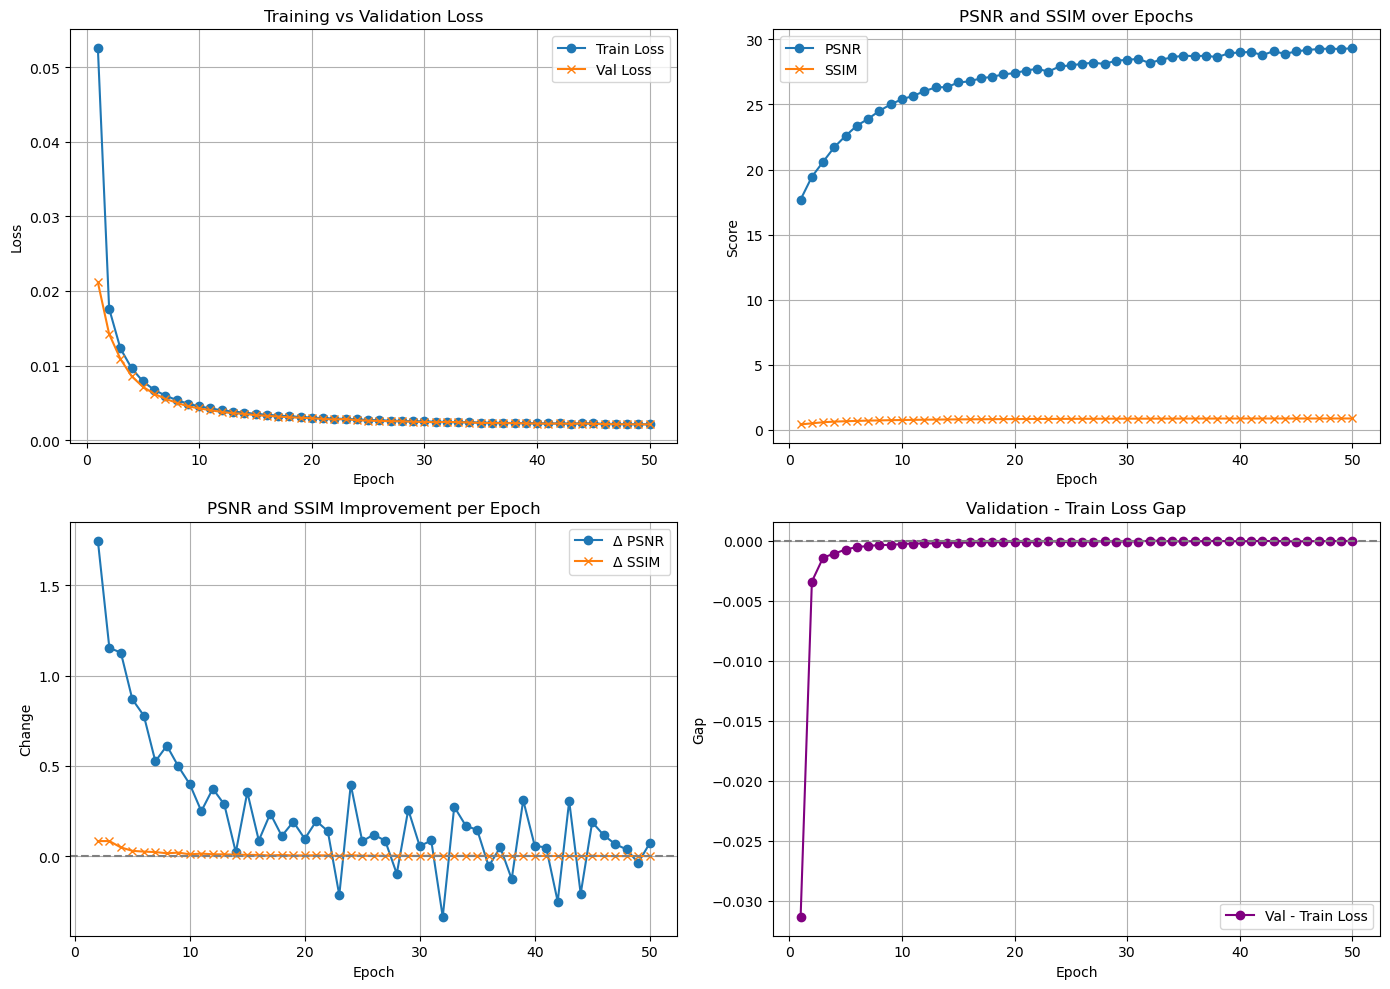

In [12]:
plotTrainingMetrics(hist_train_loss, hist_valid_loss, hist_psnr, hist_ssim)


In [13]:
def visualizeSR_Results(model: nn.Module, dataset: Dataset, num_images: int = 5):
    model.eval()
    os.makedirs("results_espcn/comparisons", exist_ok=True)

    for i in range(num_images):
        lr_img, hr_img, filename = dataset[i]
        lr_input = lr_img.unsqueeze(0).to(COMPUTE_DEVICE)

        with torch.no_grad():
            sr_img = model(lr_input).cpu().squeeze(0)

        # Converting tensors to PIL images
        lr_pil = transforms.ToPILImage()(lr_img.squeeze(0).cpu().clamp(0, 1))
        hr_pil = transforms.ToPILImage()(hr_img.clamp(0, 1))
        sr_pil = transforms.ToPILImage()(sr_img.clamp(0, 1))
        bicubic_pil = lr_pil.resize(hr_pil.size, Image.BICUBIC)

        # Converting images to numpy arrays for metric calculation
        hr_np = np.array(hr_pil).astype(np.float32)
        sr_np = np.array(sr_pil).astype(np.float32)
        bicubic_np = np.array(bicubic_pil).astype(np.float32)

        psnr_bicubic = compare_psnr(hr_np, bicubic_np, data_range=255)
        ssim_bicubic = compare_ssim(hr_np, bicubic_np, channel_axis=-1, data_range=255)
        psnr_espcn = compare_psnr(hr_np, sr_np, data_range=255)
        ssim_espcn = compare_ssim(hr_np, sr_np, channel_axis=-1, data_range=255)

        # Plot images
        fig, axs = plt.subplots(1, 4, figsize=(22, 6))

        axs[0].imshow(lr_pil)
        axs[0].set_title("Low-Res")
        axs[0].axis("off")

        axs[1].imshow(bicubic_pil)
        axs[1].set_title(f"Bicubic\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}")
        axs[1].axis("off")

        axs[2].imshow(sr_pil)
        axs[2].set_title(f"ESPCN\nPSNR: {psnr_espcn:.2f}, SSIM: {ssim_espcn:.4f}")
        axs[2].axis("off")

        axs[3].imshow(hr_pil)
        axs[3].set_title("Ground Truth")
        axs[3].axis("off")

        plt.figtext(0.5, 0.01, f"Filename: {filename}", ha="center", fontsize=10)
        plt.tight_layout(rect=[0, 0.03, 1, 1])
        plt.savefig(f"results_espcn/comparisons/{filename}")
        plt.show()


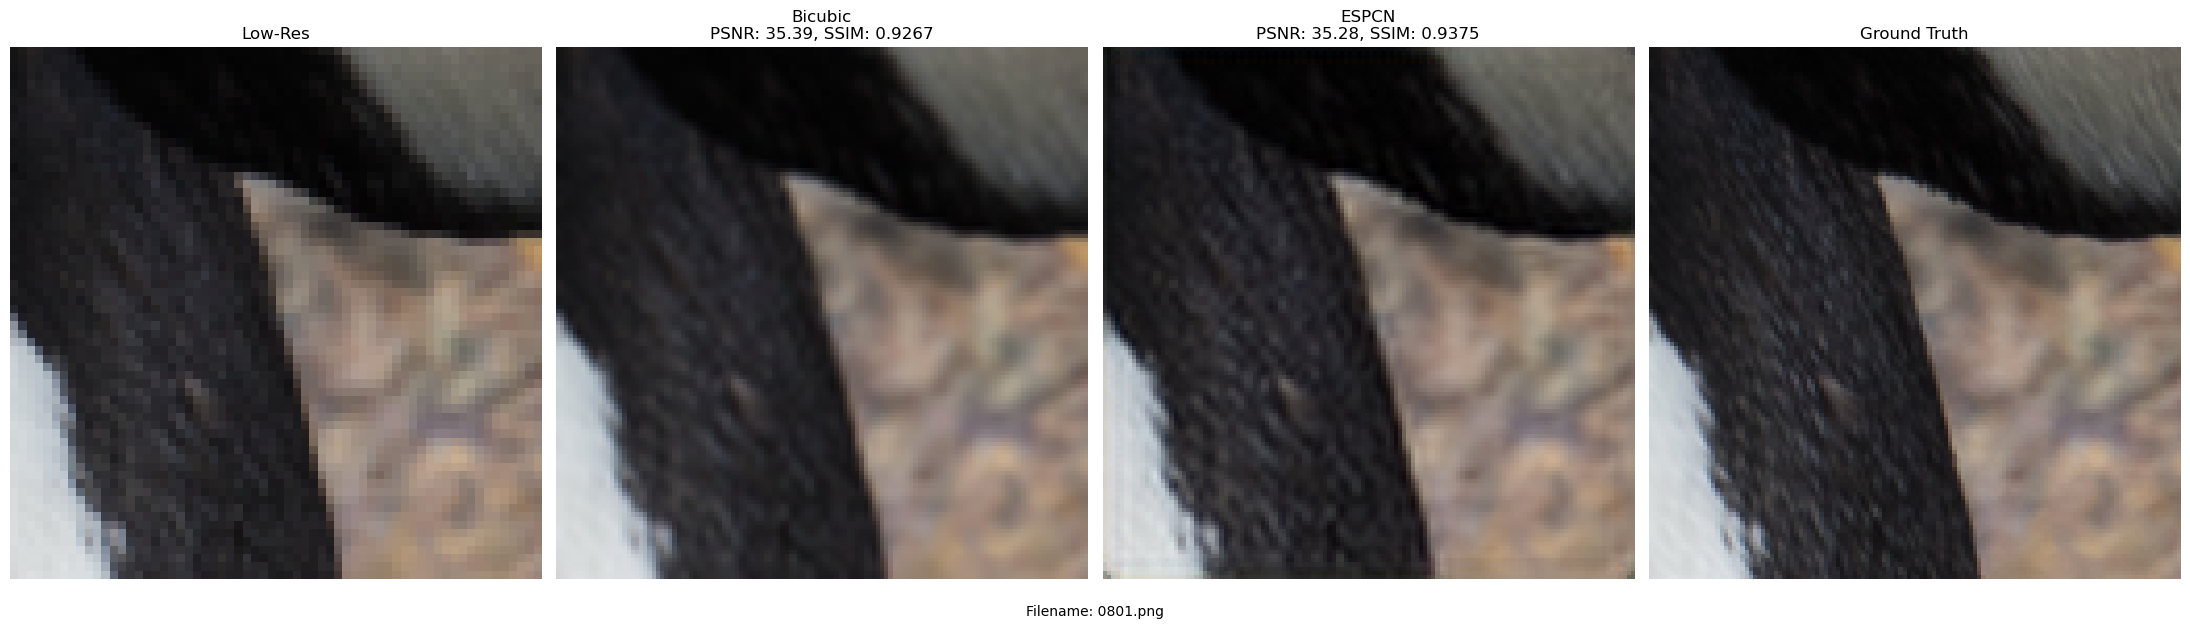

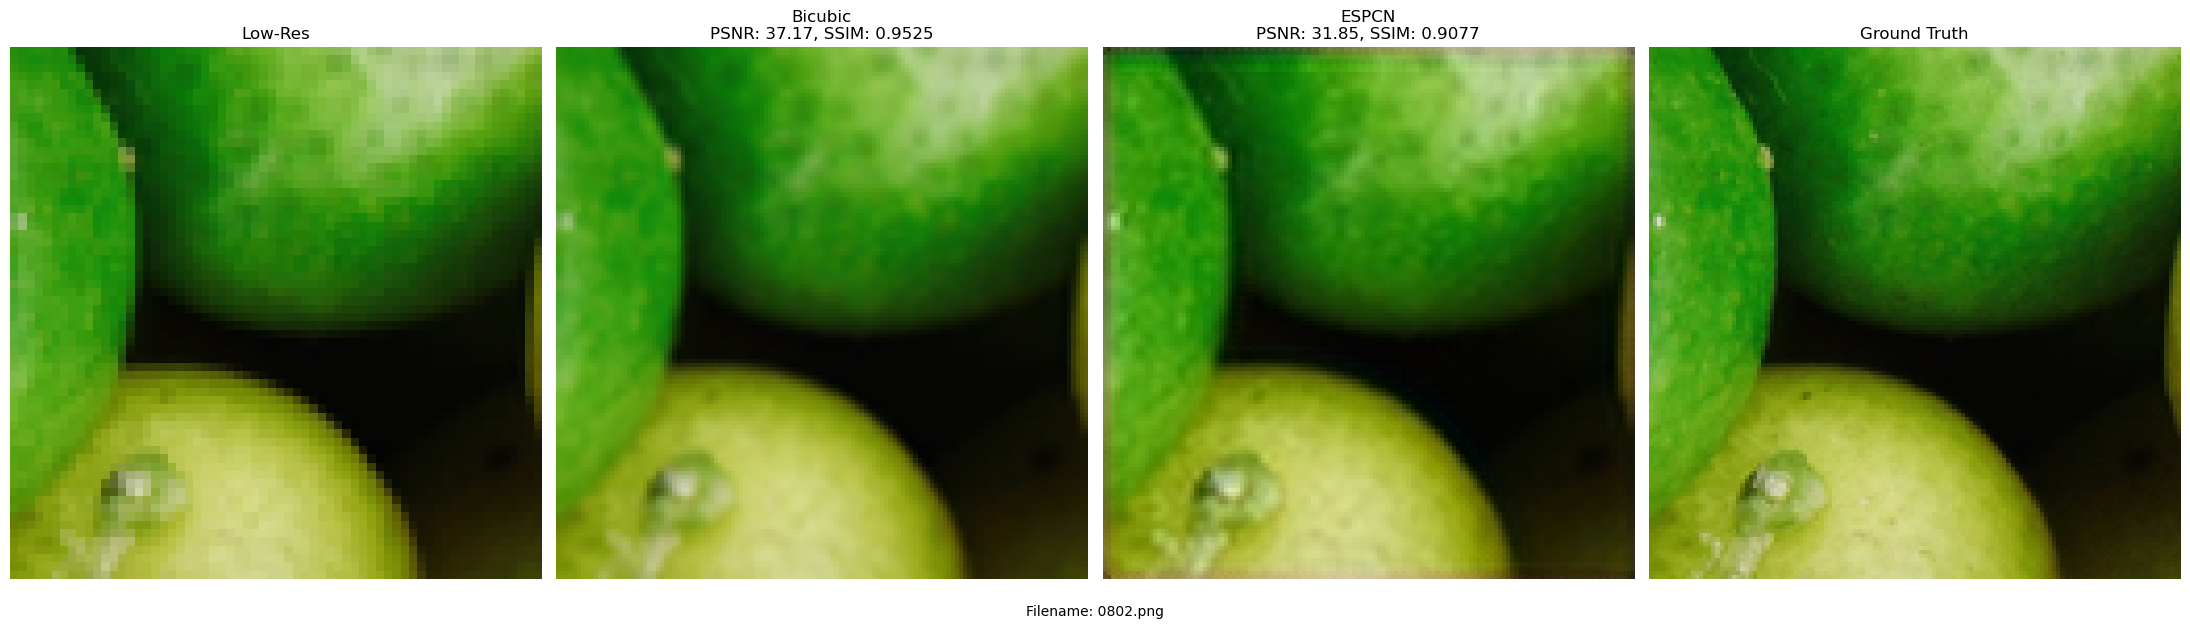

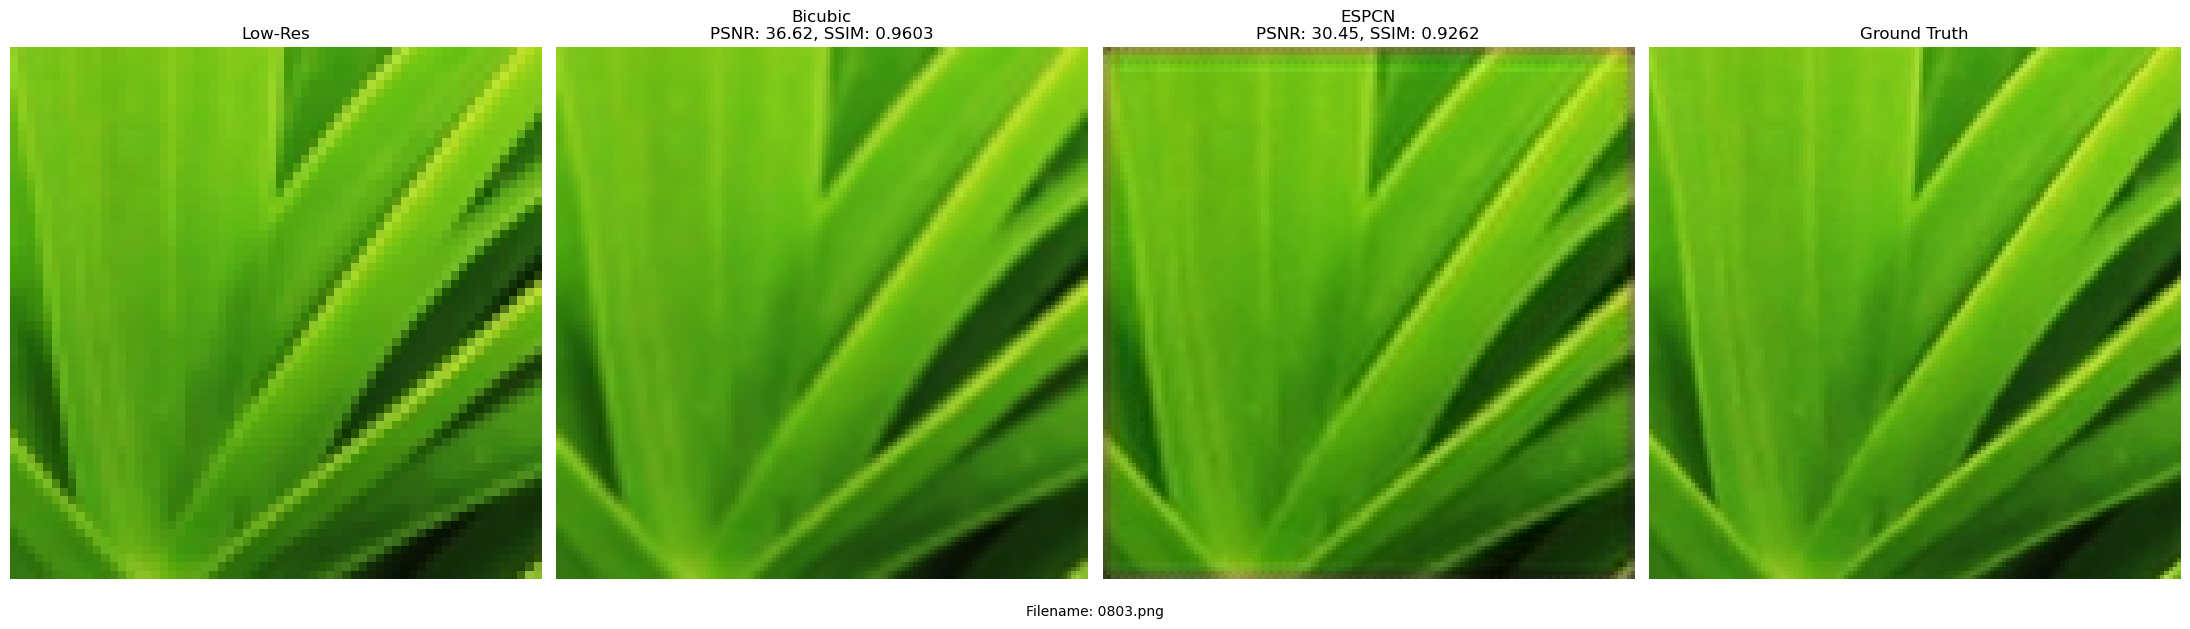

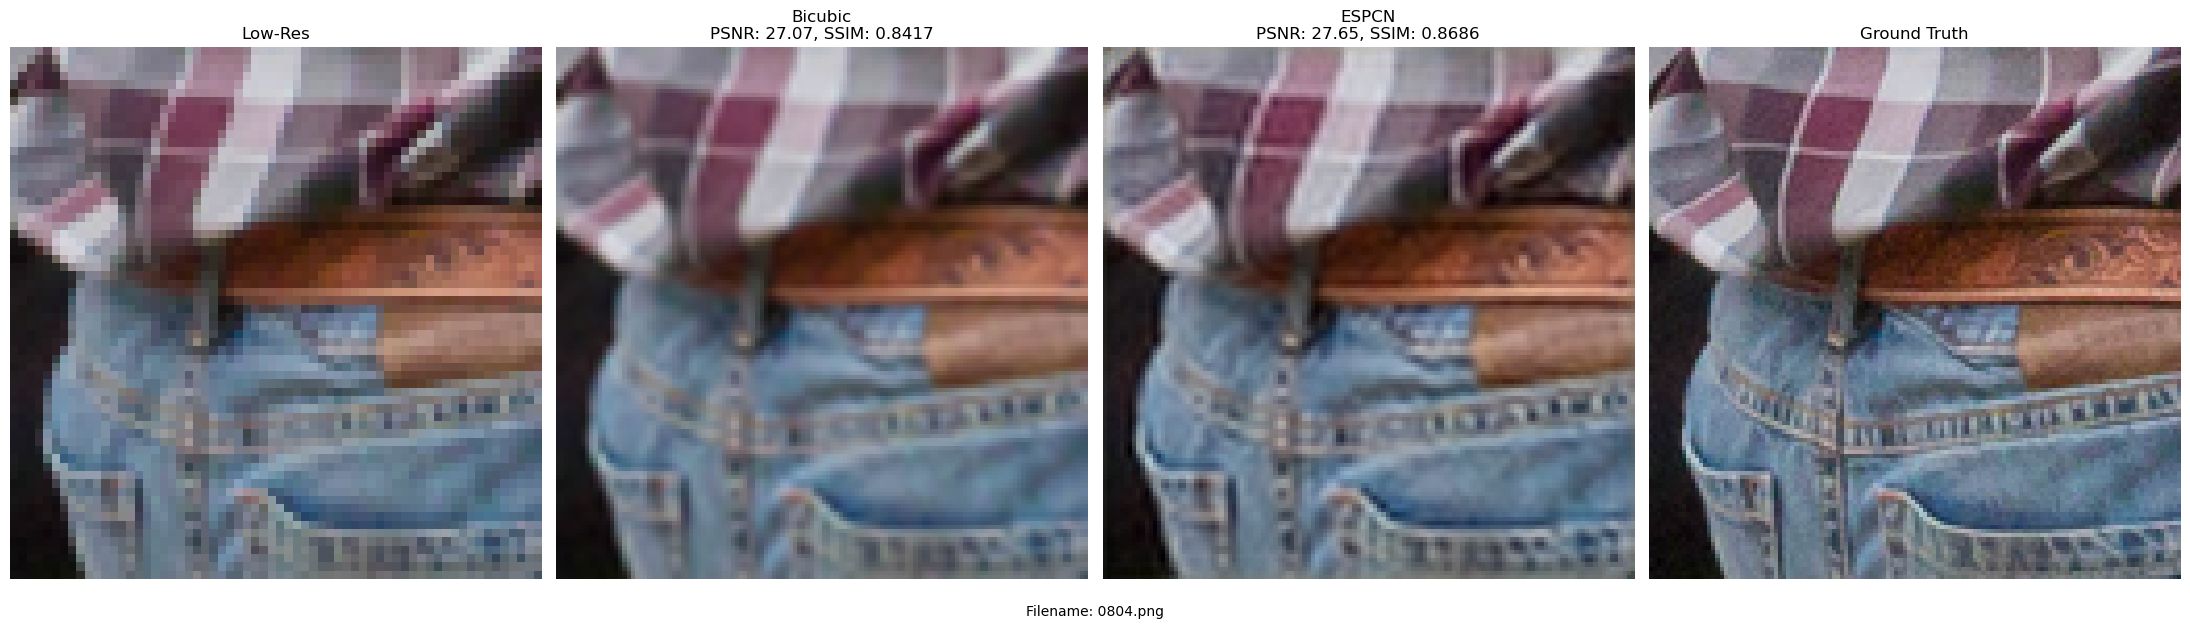

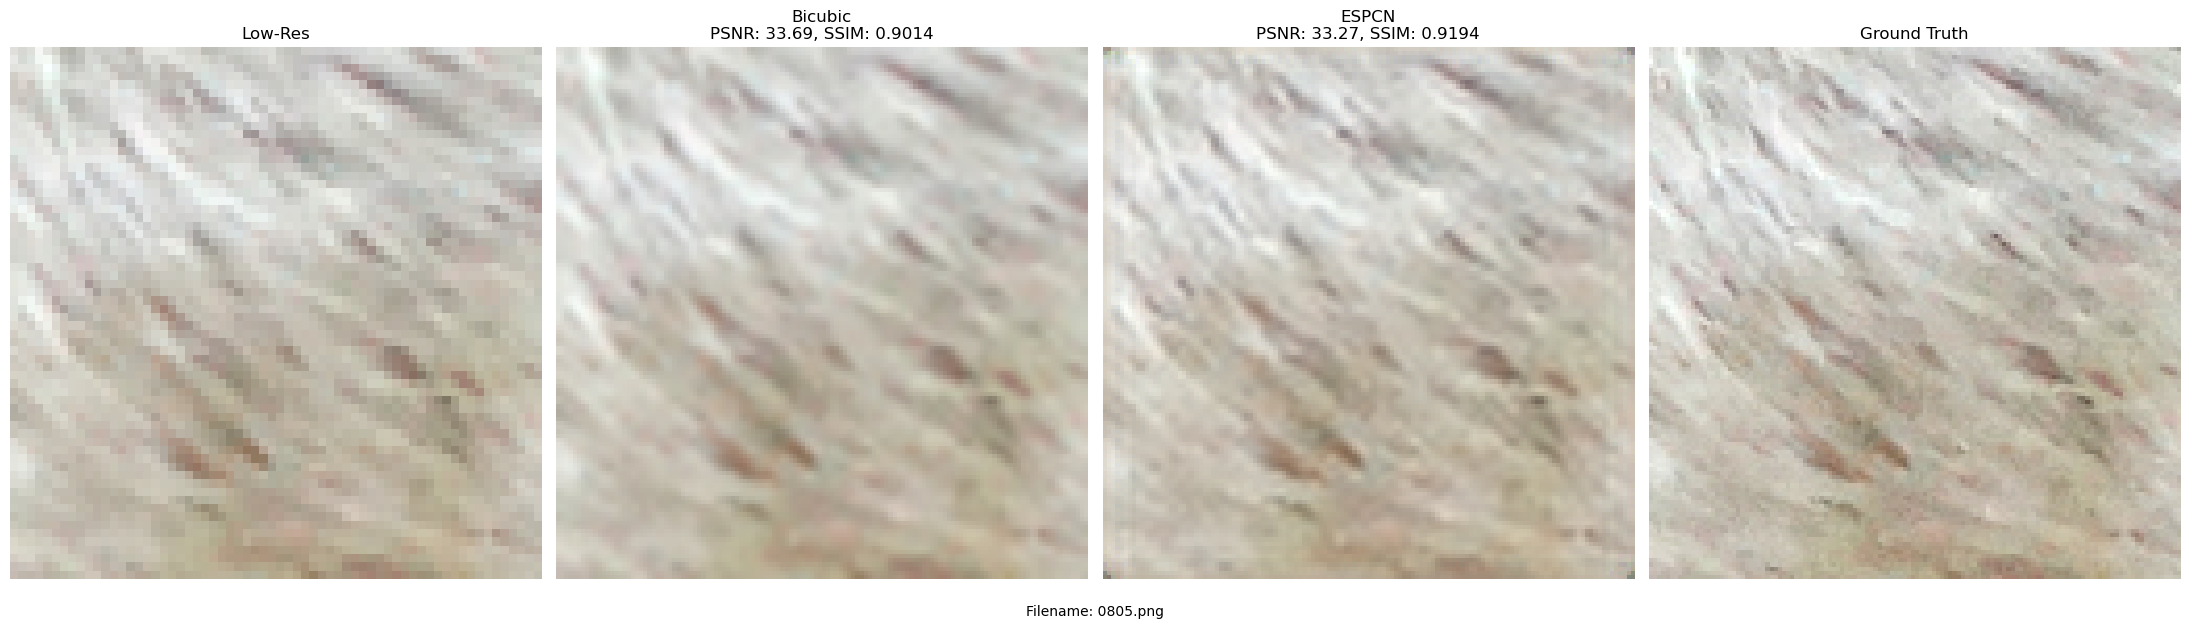

In [14]:
visualizeSR_Results(modelESPCN, dataset_valid)
